In [1]:
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing

%matplotlib inline


In [2]:
# E-step
def EStep(k_size, y, lambda_vec, coef_vec, sigma2_vec):
    '''
    y[i]
    lambda[k]
    mu[k]
    sigma[k]
    '''
    I = len(y)
    # 中身を初期化せずに配列を作成する関数である。
    # 2行, 1000列の配列を生成
    responsibility = sp.empty((k_size, I))
    
    for k in sp.arange(k_size):
        norm = stats.norm(loc=np.mean(X@coef_vec[k]), scale=sp.sqrt(sigma2_vec[k]))
        responsibility[k] = norm.pdf(y)

    responsibility = responsibility / sp.sum(responsibility, axis=0)
    return responsibility

def MStep(k_size, responsibility, y):

    lambda_vec = sp.empty(k_size)
    #mu_vec = sp.empty(k_size)
    coef_vec = []
    sigma2_vec = sp.empty(k_size)
    

    for k in sp.arange(k_size):
        r_k = responsibility[k]
        
        #coef_vec[k] = np.linalg.inv(X.T @ np.diag(r_k) @ X) @ X.T @np.diag(r_k)@y
        coef_vec.append(np.linalg.inv(X.T @ np.diag(r_k) @ X) @ X.T @np.diag(r_k)@y)
        
        #lambda_vec[k] = sp.sum(r_k) / sp.sum(responsibility)
        lambda_vec[k] = sp.sum(r_k) / responsibility.shape[1]
        
        #mu_vec[k] = sp.sum(r_k * y) / sp.sum(r_k)
        
        sigma2_vec[k] = sp.sum(r_k * (y - np.mean(X@coef_vec[k]))**2) / sp.sum(r_k)
        
    mu_vec = [np.mean(X@coef_vec[0]), np.mean(X@coef_vec[1])]
        
        
        

    return lambda_vec, mu_vec, coef_vec, sigma2_vec

In [3]:
def calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec):
    pdf = sp.zeros_like(x)

    for k in sp.arange(k_size):
        norm_k = stats.norm(loc=np.mean(X@coef_vec[k]), scale=sp.sqrt(sigma2_vec[k]))
        
        # pdf (Probability density function) 確率密度関数
        # xのときの値を取得
        pdf += lambda_vec[k] * norm_k.pdf(x)
    return pdf

# データの作成

In [52]:
df = pd.read_excel("../../data/data_covid_fix_name.xlsx")
df = df.dropna().reset_index(drop=True)

In [53]:
df.head()

,country,pop,urb,gdp,dist,hf,pf,ef,date_first,detection,status,cumul,air
0,Albania,2866376,60.319,13364.155397,6.996524e+06,7.84,8.005411,7.67,70,74.3,1,108641,303.14
1,Algeria,42228429,72.629,15481.787620,9.108277e+06,4.99,5.201489,4.77,58,12.0,1,80272,6442.44
2,Angola,30809762,65.514,6452.355165,1.049012e+07,5.40,5.979936,4.83,83,17.9,1,303691,76.94
3,Argentina,44494502,91.870,20610.568550,1.902562e+07,6.86,8.044600,5.67,65,74.9,1,92122,1516.63
4,Australia,24992369,86.012,51663.365095,7.608913e+06,8.62,9.160533,8.07,26,97.3,1,1347,75667.65


### スケーリング(標準化)

In [54]:
sscaler = preprocessing.StandardScaler() # インスタンスの作成

sscaler.fit(df[["hf", "pop",  "urb", "gdp","dist", "air", "detection"]])           # xの平均と分散を計算
X = sscaler.transform(df[["hf", "pop",  "urb", "gdp","dist", "air", "detection"]]) # xを変換

X = np.insert(X, 0, 1, axis=1)
X = pd.DataFrame(X, columns=["Intercept", "hf", "pop",  "urb", "gdp","dist", "air", "detection"])

In [55]:
#features = ["Intercept",  "gdp","dist", "air", "detection"]
features = ["Intercept", "pop", "dist", "air", "detection"]

y=df["date_first"].values
X = X.loc[:,features].values

(array([0.0030303 , 0.01060606, 0.00378788, 0.00075758, 0.00530303,
        0.03181818, 0.02651515, 0.025     , 0.00530303, 0.00151515]),
 array([ 14. ,  22.8,  31.6,  40.4,  49.2,  58. ,  66.8,  75.6,  84.4,
         93.2, 102. ]),
 <a list of 10 Patch objects>)

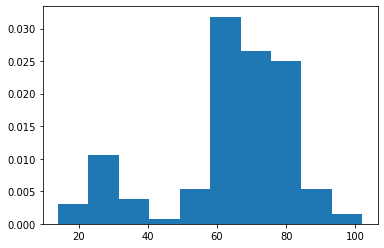

In [56]:
plt.hist(y, density=True)

# 初期値の設定  
- Rで計算済み

In [57]:
# 早期感染国のβ
coef1_first = [36.0302, 0.6561, 7.2039, -1.3490, -2.3863]

# 晩期感染国のβ
coef2_first = [68.5317, -2.4941, 1.3031, -3.5358, -4.0025]

first_df = pd.DataFrame(coef1_first, columns=["早期感染国β(初期値)"], index=features)
first_df["晩期感染国β(初期値)"] = coef2_first
first_df

,早期感染国β(初期値),晩期感染国β(初期値)
Intercept,36.0302,68.5317
gdp,0.6561,-2.4941
dist,7.2039,1.3031
air,-1.3490,-3.5358
detection,-2.3863,-4.0025


### sigmaの初期値設定方法は要検討

In [58]:
# muの初期値の計算
# mu = βx
mu1_first = np.mean(X@coef1_first)
mu2_first = np.mean(X@coef2_first)

# データを早期、晩期に分割
y_early = df["date_first"][df["date_first"]<40]
y_late = df["date_first"][df["date_first"]>40]

# sigmaの初期値
sigma1_first = np.sum((y_early - np.mean(y_early))**2)/len(y_early)
sigma2_first = np.sum((y_late - np.mean(y_late))**2)/len(y_late)

"""sigma1_first = np.sum((y - np.mean(y))**2)/len(y)
sigma2_first = np.sum((y - np.mean(y))**2)/len(y)"""

'sigma1_first = np.sum((y - np.mean(y))**2)/len(y)\nsigma2_first = np.sum((y - np.mean(y))**2)/len(y)'

In [59]:
# 混合正規分布の数
k_size = 2

# 正規分布の割合
lambda_vec=[len(y_early)/ len(y), len(y_late)/ len(y)]

# 説明変数のパラメータ
mu_vec = [mu1_first, mu2_first]

# 分散(sigma)の初期値
sigma2_vec=[sigma1_first, sigma2_first]

# coefの初期値
coef_vec = [coef1_first, coef2_first]

In [60]:
print("f1の混合比率", lambda_vec[0])
print("mu1", mu_vec[0])
print("sigma1", sigma2_vec[0])

f1の混合比率 0.15333333333333332
mu1 36.030199999999994
sigma1 27.16824196597353


In [61]:
print("f2の混合比率", lambda_vec[1])
print("mu2", mu_vec[1])
print("sigma2", sigma2_vec[1])

f2の混合比率 0.8466666666666667
mu2 68.5317
sigma2 100.76979353958708


### 初期値から生成される分布の確認

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


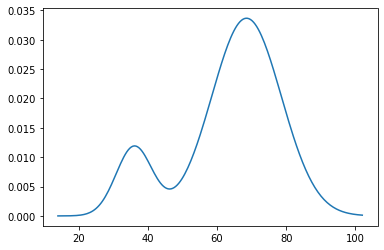

In [62]:
# データ(-6から6までを200こ)
x = sp.linspace(np.min(y), np.max(y), 200)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")

# EMアルゴリズム

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  from ipykernel import kernelapp as app
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.sum is deprecated and

i: 0 lambda [0.1584263 0.8415737] mu [39.78036014697622, 68.92834683536483] sigma2 [179.09185235 100.78432992]
i: 10 lambda [0.47830924 0.52169076] mu [61.527902678455405, 68.23902532476001] sigma2 [565.83435618  64.12715499]
i: 20 lambda [0.47834268 0.52165732] mu [61.52915879142805, 68.23756575810724] sigma2 [565.87658314  64.10325485]
i: 30 lambda [0.47834269 0.52165731] mu [61.52915918325685, 68.23756530166148] sigma2 [565.8765963  64.1032474]
i: 40 lambda [0.47834269 0.52165731] mu [61.529159183379235, 68.2375653015189] sigma2 [565.8765963   64.10324739]
i: 50 lambda [0.47834269 0.52165731] mu [61.529159183379186, 68.23756530151891] sigma2 [565.8765963   64.10324739]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and w

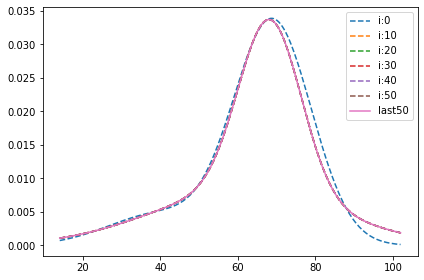

In [63]:
# 100回繰り返す
for i in sp.arange(50+1):
    # Estep
    # responsibilityの更新 
    # responsibility = EStep(k_size, y, lambda_vec, mu_vec, sigma2_vec)
    responsibility = EStep(k_size, y, lambda_vec, coef_vec, sigma2_vec)
    
    # Mstep
    # 混合割合, 平均, 分散の更新
    lambda_vec, mu_vec, coef_vec, sigma2_vec = MStep(k_size, responsibility, y)
    #mu_vec = [np.mean(X@coef_vec[0]), np.mean(X@coef_vec[1])]
    
    if i % 10 == 0:
        print("i:", i, "lambda", lambda_vec, "mu", mu_vec, "sigma2", sigma2_vec)
        plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label=f"i:{i}", linestyle="--")
        
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label=f"last{i}", linestyle="-")

plt.legend()
plt.tight_layout()
plt.show()

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


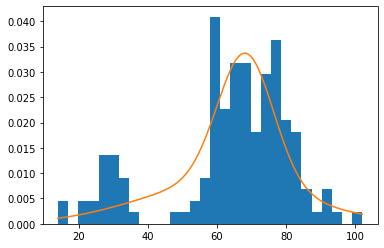

In [64]:
plt.hist(y, bins=30, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")

#### 注  
- mu1, mu2は反転する可能性があるため、f1, f2の混合比率を確認

In [65]:
print("f1の混合比率", lambda_vec[0])
print("mu1", mu_vec[0])
print("sigma1", sigma2_vec[0])

print("f2の混合比率", lambda_vec[1])
print("mu2", mu_vec[1])
print("sigma2", sigma2_vec[1])

f1の混合比率 0.4783426900070953
mu1 61.529159183379186
sigma1 565.8765963033838
f2の混合比率 0.5216573099929047
mu2 68.23756530151891
sigma2 64.10324739420965


###  推定された分布の可視化

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  This is separate from the ipykernel package so we can avoid doing imports until


(array([0.00529129, 0.        , 0.01587386, 0.01587386, 0.03703901,
        0.05291287, 0.04762159, 0.03703901, 0.04762159, 0.01587386]),
 array([45.93487863, 49.56930033, 53.20372202, 56.83814372, 60.47256541,
        64.1069871 , 67.7414088 , 71.37583049, 75.01025219, 78.64467388,
        82.27909557]),
 <a list of 10 Patch objects>)

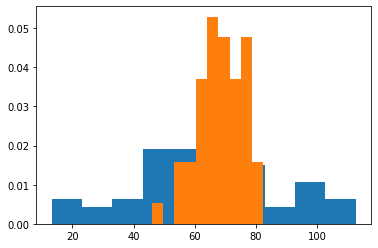

In [66]:
# 推定された分布の可視化
new_N1 = stats.norm(loc=mu_vec[0], scale=sp.sqrt(sigma2_vec[0]))
new_N2 = stats.norm(loc=mu_vec[1], scale=sp.sqrt(sigma2_vec[1]))

# rvs (Random variates) 確率変数
new_s1 = new_N1.rvs(size=int(lambda_vec[0]*100))
new_s2 = new_N2.rvs(size=int(lambda_vec[1]*100))


#plt.hist(y, bins=30, density=True)

plt.hist(new_s1, density=True)
plt.hist(new_s2, density=True)


### # 推定されたパラメータ

In [50]:
res_df = pd.DataFrame(coef_vec[0].round(4), index=features, columns=["早期感染国"])
res_df["晩期感染国"] = coef_vec[1].round(4)
res_df

,早期感染国,晩期感染国
切片,61.5292,68.2376
gdp,-4.7828,-3.1054
dist,8.7436,0.6159
air,-2.8607,-1.6878
detection,-8.4602,-2.6126


In [51]:
# 初期値パラメータ
first_df

,早期感染国β(初期値),晩期感染国β(初期値)
切片,37.1590,68.7711
gdp,-0.9750,-3.9135
dist,7.3992,0.6371
air,-1.0318,-2.1701
detection,-2.6020,-3.4417


# 改善事項  
- p値  
- 信頼区間  
- AIC  
  
  
- 対数化しない場合  
- 変数選択  
- f1とf2で変数を帰る